In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group #generator for random orthogonal matrix
from sklearn.preprocessing import normalize
import matplotlib
%matplotlib inline

In [2]:
def data_generator(dim, noise_bound, gt_dict=None):
    if gt_dict is not None:
        W = gt_dict
    else:
        W = ortho_group.rvs(dim)
    s = np.random.multinomial(1, [float(1/dim)]*dim)
    sigma = float(noise_bound)/(dim)**(0.5)
    eps = np.random.normal([0.0]*dim, sigma)
    norm = np.linalg.norm(eps)
    if norm > noise_bound:
        eps = noise_bound * eps/norm
    #return np.dot(W,s)+eps, eps
    #print(np.dot(W,s))
    return np.dot(W,s)+eps
    
def batch_data_generator(dim, noise_bound, batch_size, gt_dict=None):
    def map_function(null):
        return data_generator(dim, noise_bound, gt_dict)
    
    return list(map(map_function, [0]*batch_size))


# x, eps = data_generator(2,0.1)
# #print(np.linalg.norm(eps))
# print(x)

list_x = batch_data_generator(2,0.1,5)
list_x

[array([ 1.06675339, -0.04445366]),
 array([-0.48614008, -0.91490363]),
 array([ 0.61252821,  0.69055214]),
 array([ 0.72057894, -0.73735813]),
 array([ 0.792623  ,  0.42707743])]

In [3]:
max(0, [0,-1,2])

[0, -1, 2]

In [4]:
## define bias initialization
def bias_init(weights, norm, batch_size, batch_data_generator, dim, noise_bound):
    assert norm > 1, 'the norm value is invalid!'
    ## generate a batch sample
    batch_x = batch_data_generator(dim, noise_bound, batch_size)
    ## calculate average inner product
    avg_proj = tf.reduce_mean(tf.matmul(weights, tf.transpose(np.array(batch_x))), axis=1)
    return tf.subtract(tf.divide(avg_proj, norm**2), avg_proj)

In [5]:
## data model parameters
dim = 2
noise_bound = 0.1

## architecture parameters
width = 2*dim
activation = 'relu'

## algorithmic parameters
init_batch_size = 200
norm = 2
rescale_param = 1/float(norm**2) - 1
t_o = 100
c_prime = 10
##
train_steps = 1000

In [6]:
tf.reset_default_graph()

In [7]:
gt_dict = ortho_group.rvs(dim) # generate ground-truth dictionary
init_weights = tf.random_normal([width, dim], dtype=tf.float64) # init random weights
init_bias = bias_init(init_weights, norm, init_batch_size, batch_data_generator, dim, noise_bound)
with tf.Session() as sess:
    init_weights_ = sess.run(init_weights)
    init_bias_ = sess.run(init_bias)

In [8]:
## evaluation metric
def cosine_squared_distances(weights, dictionary):
    #print(weights.shape)
    #print(normalize(weights))
    w_normalized = normalize(weights)
    #w_normalized = 0.5*weights
    raw_scores = np.square(np.matmul(w_normalized, np.transpose(dictionary)))
    max_scores = np.max(raw_scores, axis=0) # best approximation for each dict item
    return max_scores, raw_scores, min(max_scores)
def cos_sq_avg_distances(weights, dictionary):
    max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = [1]*len(max_scores)-max_scores
    return np.mean(max_scores)
def cos_sq_min_distances(weights, dictionary):
    max_scores,_,_ = cosine_squared_distances(weights, dictionary)
    max_scores = [1]*len(max_scores)-max_scores
    return np.min(max_scores)


In [9]:
init_weights_

array([[-1.24626159, -0.0881757 ],
       [ 0.6835569 , -1.0049918 ],
       [-0.93737295, -0.50354038],
       [ 0.44191751, -0.56173612]])

## Original SGD Training

In [10]:
## Relu - autoencoder model with tied weights

### parameters to learn
weights = tf.Variable(init_weights_, dtype=tf.float64)
#bias = tf.Variable(init_bias_, dtype=tf.float64)
bias = tf.Variable(np.zeros(width), dtype=tf.float64)
create_row_normalize_op = tf.assign(weights, norm * tf.nn.l2_normalize(weights, dim=1))
### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.squeeze(tf.matmul(tf.nn.relu(h), weights))
    else:
        print('activation function not implemented')
        exit(0)
def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    print(x_hat.get_shape())
    return tf.reduce_sum(tf.square(x - x_hat))

#x_gt = tf.placeholder(tf.float64, [dim,])
mini_batch_size = 100
batch_x = tf.placeholder(tf.float64, [mini_batch_size, dim])

### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = 0.01
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(data_wise_mean_sq_loss(batch_x, weights, bias))

(100, 2)


In [11]:
## standard learning-rate decayed SGD training

#create_row_normalize_op = tf.assign(weights, tf.nn.l2_normalize(weights, dim=1))
# eta = 0.1
# update_bias_op = tf.assign(bias, 
#                     bias*(1-eta)+eta*tf.squeeze(tf.matmul(weights, tf.expand_dims(x_gt, axis=1)))*rescale_param)

#gt_dict = ortho_group.rvs(dim) # generate ground-truth dictionary
#test_sample = batch_data_generator(dim, noise_bound, 100)
avg_scores_list = list()
min_scores = list()
control_weight = False
for n_runs in range(10):
    avg_scores = list()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(train_steps):
            if i==0:
                avg_scores.append(cos_sq_avg_distances(init_weights_, gt_dict))
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            #x = data_generator(dim, noise_bound, gt_dict)
            x = batch_data_generator(dim, noise_bound, mini_batch_size, gt_dict)
            #init_weights_ = sess.run(init_weights)
            _, weights_, bias_ = sess.run([train_op, weights, bias] , feed_dict={batch_x: x})
            if control_weight:
                _, weights_ = sess.run([create_row_normalize_op, weights]) 
            n_steps = sess.run(increment_global_step_op)
            avg_scores.append(cos_sq_avg_distances(weights_, gt_dict))
            min_scores.append(cos_sq_min_distances(weights_, gt_dict))
    avg_scores_list.append(avg_scores)
            #if (n_steps-t_o) % 100 == 0:
#                 print('Training at %d-th iteration'% (n_steps-t_o))
#                 print('cosine distances',)
#                 print(cosine_squared_distances(weights_, gt_dict)[0])
#                 print('Cosine best approximation distance at init', cosine_squared_distances(init_weights_, gt_dict)[0])
        #weights_final = weights_.eval()
        #bias_final = bias_.eval()
#     print('Cosine best approximation distance at init', cosine_squared_distances(init_weights_, gt_dict)[0])
#     print('Cosine best approximation after updates', cosine_squared_distances(weights_, gt_dict)[0])

In [12]:
cosine_squared_distances(init_weights_, gt_dict)[0]

array([ 0.65766417,  0.99035957])

## Modified SGD Training

In [13]:
## algorithmic params
mini_batch_size = 1
b_appx_batch_size = 100

In [14]:
## Relu - autoencoder model with tied weights

### parameters to learn
#init_weights = tf.random_normal([width, dim], dtype=tf.float64)
weights = tf.Variable(init_weights_, dtype=tf.float64)
bias = tf.Variable(init_bias_, trainable=False, dtype=tf.float64)

### define model and loss
def encoder(weights, bias, x):
    return tf.add(tf.matmul(x, tf.transpose(weights)), bias)
def decoder(weights, h, activation):
    if activation == 'relu':
        return tf.squeeze(tf.matmul(tf.nn.relu(h), weights))
    else:
        print('activation function not implemented')
        exit(0)
def data_wise_mean_sq_loss(x, weights, bias):
    x_hat = decoder(weights, encoder(weights, bias, x), 'relu')
    #print(x_hat.get_shape())
    return tf.reduce_sum(tf.square(x - x_hat))

def batch_wise_mean_sq_loss(batch_x, weights, bias):
    batch_x_hat = decoder(weights, encoder(weights, bias, batch_x), 'relu')
    print(batch_x_hat.get_shape())
    return tf.reduce_mean(tf.square(batch_x - batch_x_hat), axis=1)

#x_gt = tf.placeholder(tf.float64, [dim,])
batch_x_gt = tf.placeholder(tf.float64, [mini_batch_size, dim])
batch_x_update_b = tf.placeholder(tf.float64, [b_appx_batch_size, dim])
### define optimizer  
global_step = tf.Variable(t_o, trainable=False)
learning_rate = c_prime
decay_steps = 1
decay_rate = 1.0
increment_global_step_op = tf.assign(global_step, global_step+1)
##
learn_rate = tf.train.inverse_time_decay(tf.cast(learning_rate, tf.float64), global_step, decay_steps, decay_rate)
#learn_rate = 0.01
train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(batch_wise_mean_sq_loss(batch_x_gt, weights, bias))

(2,)


In [15]:
## Norm-controlled SGD training

create_row_normalize_op = tf.assign(weights, norm * tf.nn.l2_normalize(weights, dim=1))
#batch_x = batch_data_generator(dim, noise_bound, b_appx_batch_size)
# update_bias_op = tf.assign(bias, 
#                     tf.squeeze(tf.matmul(weights, tf.expand_dims(x_gt, axis=1)))*rescale_param)

def get_bias_update(batch_x, weights, bias, width, batch_size, rescale_param):
    if tf.shape(batch_x)==1:
        print('wrong')
    else:
#         relu_activation = tf.nn.relu(tf.transpose(
#             tf.add(tf.transpose(tf.matmul(weights, batch_x)),bias)))
        #avg_activation = tf.reduce_mean(relu_activation, axis=1)
        projection = tf.transpose(tf.matmul(batch_x, tf.transpose(weights)))    # width by batch_size
        #print(projection.get_shape())
        relu_activation = tf.nn.relu(tf.transpose(tf.add(tf.transpose(projection), bias)))
        #print(relu_activation.get_shape())
        zero = tf.constant(0, dtype=tf.float64)
        where = tf.not_equal(relu_activation, zero) ## logical indexing of relu_activation
        indices = tf.where(where) ## indices of nonzero entries in relu_activation
        #print('where shape', where.get_shape())
        #temp = tf.count_nonzero(where,axis=1)
        #print('nonzero', temp.get_shape())
        ## calculate empirical prob of firing
        nnz = tf.cast(tf.count_nonzero(where, axis=1), tf.float64)
        zero_of_nnz = tf.equal(nnz, zero)
        offsetted_nnz = tf.where(zero_of_nnz, tf.ones([width], dtype=tf.float64), nnz)
        prob_firing = tf.divide(nnz, tf.cast(batch_size,tf.float64))
        
        ## calculate empirical mean of projected value
        shape = tf.constant([width, batch_size], dtype=tf.int64)
        #print(indices.get_shape())
        updated = tf.scatter_nd(indices, tf.gather_nd(projection, indices), shape)
        updated = tf.reduce_sum(updated, axis=1)#
        #offsetted_nnz = tf.scatter_add(nnz, indices_of_zero_in_nnz, tf.ones_like(indices_of_zero_in_nnz))
        updated = tf.divide(updated, offsetted_nnz) * rescale_param ## shape = (width,)
        #print('updated shape', updated.get_shape())
        #print(relu_activation.get_shape())
        new_bias = tf.add(tf.multiply(prob_firing,updated), tf.multiply(tf.subtract(tf.cast(1,tf.float64),prob_firing),bias))
        return new_bias

new_bias = get_bias_update(batch_x_update_b, weights, bias, width, b_appx_batch_size, rescale_param)
update_bias_op = tf.assign(bias, new_bias)



#test_sample = batch_data_generator(dim, noise_bound, 100)

min_scores_mod = list()
weights_cache = init_weights_
#bias_cache = init_bias_
avg_scores_mod_list = list()

for n_runs in range(10):
    avg_scores_mod = list()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(train_steps):
            if i == 0:
                avg_scores_mod.append(cos_sq_avg_distances(init_weights_, gt_dict))
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            batch_x = batch_data_generator(dim, noise_bound, mini_batch_size, gt_dict)
            #init_weights_ = sess.run(init_weights)
            #sess.run([train_op] , feed_dict={x_gt: x})
            sess.run([train_op] , feed_dict={batch_x_gt: np.array(batch_x)})
            _,weights_ = sess.run([create_row_normalize_op, weights])  ## row-normalization of updated weights

            ## get a fresh sample and update bias
            #x = data_generator(dim, noise_bound, gt_dict)[0]
            #bias_ = sess.run(update_bias_op, feed_dict={x_gt: x})  ## update bias using updated weights
            batch_x_for_b = batch_data_generator(dim, noise_bound, b_appx_batch_size, gt_dict)
            _, bias_ =sess.run([update_bias_op, bias], 
                              feed_dict={batch_x_update_b: np.array(batch_x_for_b)})


            n_steps = sess.run(increment_global_step_op)
            avg_scores_mod.append(cos_sq_avg_distances(weights_, gt_dict))
            min_scores_mod.append(cos_sq_min_distances(weights_, gt_dict))
    avg_scores_mod_list.append(avg_scores_mod)
#         if (n_steps-t_o) % 100 == 0:
#             print('Training at %d-th iteration'% (n_steps-t_o))
#             print('cosine distances',)
#             print(cosine_squared_distances(weights_, gt_dict)[0])
#             #print('number of bias entries not updated is %d'%len(ind_))
#             print('change of weights', sess.run(tf.norm(weights_ - weights_cache)))
#             #print('change of bias', tf.norm(bias_ - bias_cache))
#             weights_cache = weights_
            #bias_cache = bias_
    #weights_final = weights_.eval()
    #bias_final = bias_.eval()
        

In [16]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#best_appx, all_appx = cosine_distances(weights_, gt_dict)
#print(best_appx)
#print('best of init', cosine_distances(init_weights_, gt_dict)[-1])
print('at init', cosine_squared_distances(init_weights_, gt_dict)[0])
print('after updates', cosine_squared_distances(weights_, gt_dict)[0])

('at init', array([ 0.65766417,  0.99035957]))
('after updates', array([ 0.9962396 ,  0.99813279]))


In [17]:
avg1 = np.mean(np.array(avg_scores_list), axis=0)
std1 = np.std(np.array(avg_scores_list), axis=0)
avg2 = np.mean(np.array(avg_scores_mod_list), axis=0)
std2 = np.std(np.array(avg_scores_mod_list), axis=0)
len(std2)

1001

## Plotting


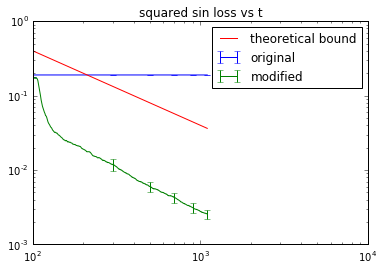

In [19]:
time_pts = range(t_o, t_o+train_steps+1)
appx_func = [40/float(t) for t in time_pts]
fig, ax = plt.subplots()
# ax.plot(time_pts, avg1[:101])
# ax.plot(time_pts, avg2[:101])
ax.errorbar(time_pts, avg1, yerr=std1, errorevery=200, label='original')
ax.errorbar(time_pts, avg2, yerr=std2, errorevery=200, label='modified')
# ax.plot(time_pts, avg_scores, label='original')
# ax.plot(time_pts, avg_scores_mod, label='modified')
ax.plot(time_pts, appx_func, label='theoretical bound')
# ax.plot(time_pts, [cos_sq_avg_distances(init_weights_, gt_dict)]*train_steps, label='initial loss')
# fig.savefig('original.eps')
ax.set_title('squared sin loss vs t')
ax.legend(loc=1)
fig.savefig('original6' + 'to_' + str(t_o) + '_cprme_' + str(c_prime) + '.eps')
ax.loglog()
fig.savefig('log6' + 'to_' + str(t_o) + '_cprme_' + str(c_prime) + '.eps')